In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook, tnrange
from itertools import product


In [ ]:
pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48443 sha256=0b442dc6207d4a9b2d132eaee0d114b77c5208c41c03f2ac4812da860cdd6431
  Stored in directory: /root/.cache/pip/wheels/76/33/ef/5f332226e13a5089c6dd4b01cc2bcb59491d18f955fa2d3807
Successfully built pykalman


In [ ]:
df4=pd.read_csv("Final_whole_data.csv")
df4=df4.dropna(axis=0)
df4['tirumala']=(df4['tirumala']*100/max(df4['tirumala'])).astype(int)
y=df4['Pilgrims']

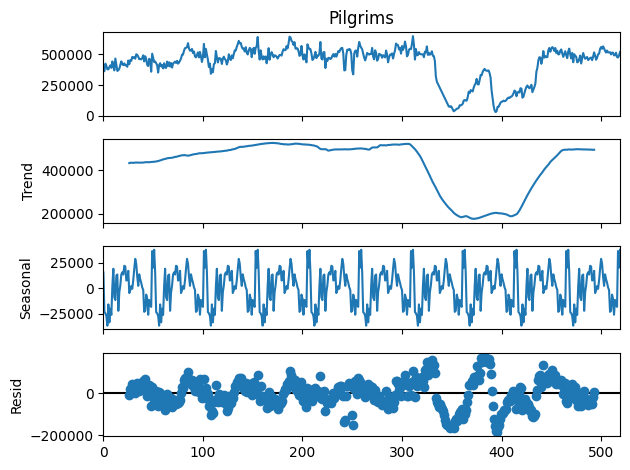

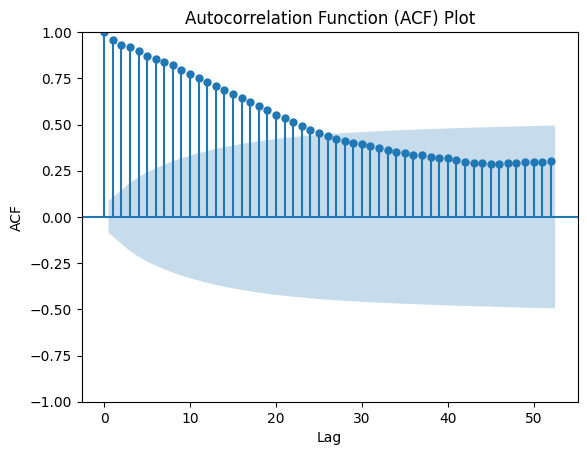

In [ ]:
result=seasonal_decompose(df4['Pilgrims'],model='additive',period=52)
result.plot()
plt.show()
plot_acf(df4['Pilgrims'], lags=52)  # Assuming 1 year peodicity
plt.title("Autocorrelation Function (ACF) Plot")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

In [ ]:
x= df4.iloc[:, 1:14]
pca = PCA(n_components = 5)
X2D = pca.fit_transform(x)
print(pca.explained_variance_ratio_)
dft=pd.DataFrame(X2D)

[0.41486661 0.25168113 0.07641294 0.06333555 0.04357787]


In [ ]:
result = adfuller(y)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])
diff= y.diff()
diff.drop([0], axis=0, inplace=True)
result = adfuller(diff)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])
y=pd.DataFrame(diff)

ADF Test Statistic: -2.41
5% Critical Value: -2.87
p-value: 0.14
ADF Test Statistic: -8.03
5% Critical Value: -2.87
p-value: 0.00


In [ ]:
y=y.reset_index(drop=True)
dft_reset = dft.reset_index(drop=True)
test = y.join(dft_reset)

In [ ]:
dft_reset.index
print(y.index)
print(dft_reset[:len(dft_reset)-1].index)

RangeIndex(start=0, stop=519, step=1)
RangeIndex(start=0, stop=519, step=1)


In [ ]:
 def optimize_SARIMA(parameters_list, d, D, s, exog,endog):
    """
        Return dataframe with parameters, corresponding AIC and SSE

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(endog,exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except Exception as e:
            print(e)

            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    print( result_df)
    return result_df

In [ ]:
# SARIMA parameter optimization (similar to your code)
p = range(0, 3, 1)
d = 1
q = range(0, 3, 1)
P = range(0, 3, 1)
D = 1
Q = range(0, 3, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
result_df = optimize_SARIMA(parameters_list, d, D, s, dft_reset[:len(dft_reset)-11], y[:len(y)-10])
f_aic = 0

if result_df['AIC'].shape[0] > 2 and result_df['AIC'][1] - result_df['AIC'][0] > 3 * (result_df['AIC'][2] - result_df['AIC'][1]):
    f_aic = 1

best_model_params = result_df['(p,q)x(P,Q)'][f_aic]
best_model = SARIMAX( y[:len(y)-10],exog=dft_reset[:len(dft_reset)-11], order=(best_model_params[0], d, best_model_params[1]), seasonal_order=(best_model_params[2], D, best_model_params[3], s)).fit(disp=0)


<ipython-input-13-f828a1f629ee>:14: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/81 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3

     (p,q)x(P,Q)           AIC
0   (2, 2, 0, 1)  12268.800288
1   (2, 1, 0, 2)  12269.156000
2   (2, 1, 1, 1)  12269.170061
3   (2, 1, 0, 1)  12271.055813
4   (2, 2, 0, 2)  12271.750190
..           ...           ...
76  (1, 0, 1, 0)  12550.143285
77  (0, 0, 2, 0)  12626.960914
78  (1, 0, 0, 0)  12655.078536
79  (0, 0, 1, 0)  12678.013989
80  (0, 0, 0, 0)  15438.664970

[81 rows x 2 columns]


In [ ]:
sarima_forecasts_label = best_model.forecast(steps=10, exog=test[[0, 1, 2, 3, 4]].iloc[-10:])


In [ ]:
kf = KalmanFilter(initial_state_mean=0, n_dim_state=1, n_dim_obs=1)

# Apply the Kalman filter to the SARIMA forecasts
kf = kf.em(sarima_forecasts_label, n_iter=5)
filtered_state_means,filtered_cov= kf.filter(sarima_forecasts_label)
print(filtered_state_means)
# Extract the estimated true underlying states
filtered_state_means_array = np.array(filtered_state_means)

# Now you can use squeeze() on the NumPy array
true_state_estimates = filtered_state_means_array.squeeze()

# The true next two labels can be obtained from the original data
true_next_labels =test['Pilgrims'].iloc[-10:].values

# Calculate the Mean Squared Error (MSE) to measure accuracy

In [ ]:
sarima_forecasts_label.reset_index(drop=True,inplace=True)
pred=[]
pred.append(df4['Pilgrims'].iloc[-10]+sarima_forecasts_label[0])
for i in sarima_forecasts_label[1:]:
  pred.append(pred[-1]+i)

In [ ]:
pred

[508188.15360245376,
 521984.6650331124,
 521639.69828478317,
 526026.3575900643,
 528973.8691326712,
 536835.0898396899,
 531324.3376993235,
 529388.4900596119,
 532950.8445381495,
 542908.3938722861]

In [ ]:
fig = go.Figure()

# Add a line trace for the original data
fig.add_trace(go.Scatter(x=df4['Date'].iloc[-10:], y=df4['Pilgrims'].iloc[-10:], mode='lines', name='Original Data'))

# Add a line trace for the prediction
fig.add_trace(go.Scatter(x=df4['Date'].iloc[-10:], y=pred, mode='lines', name='Prediction'))

# Customize the layout if needed
fig.update_layout(title='Original Data and Prediction',
                  xaxis_title='X-axis',
                  yaxis_title='Y-axis')

# Show the Plotly figure
fig.show()

In [ ]:
mse = mean_absolute_percentage_error(df4['Pilgrims'].iloc[-10:], pred)
print("(MAE):", mse*100)

(MAE): 5.7953874822179525
